In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns 
import os 
from scipy import stats 
from statsmodels.tsa.api import VAR, ExponentialSmoothing, Holt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error,mean_squared_error
import math 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [3]:
dataset_path = Path().resolve().parent/'dataset/HomeC.csv'
df = pd.read_csv(dataset_path)
df.head(3)

C:\Users\User\anaconda3\envs\time-series-labs\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


# Preprocessing dataset

In [4]:
#remove kW
df.columns = [i.replace(' [kW]', '') for i in df.columns]
#combine similar objects
df['Furnace'] = df[['Furnace 1','Furnace 2']].sum(axis=1)
df['Kitchen'] = df[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1)
#remove unused objects
df.drop(['Furnace 1','Furnace 2','Kitchen 12','Kitchen 14','Kitchen 38','icon','House overall','summary','Solar'],axis = 1,inplace = True)
#remove last row as the values are NaN
df = df[0:-1] ## == dataset[0:dataset.shape[0]-1] == dataset[0:len(dataset)-1] == dataset[:-1]
#replace object in cloudCover with float
df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
df['cloudCover'] = df['cloudCover'].astype('float')
#set date time as index and drop date column
date_time = pd.date_range('2016-01-01 00:00',periods=len(df), freq='min')
df = df.set_index(date_time)
df = df.drop(['time'],axis=1)
df

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
2016-01-01 00:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.082617,0.000567
2016-01-01 00:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.084533,0.000567
2016-01-01 00:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.083017,0.000617
2016-01-01 00:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.175417,0.000650
2016-01-01 00:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.300917,0.000783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 22:25:00,1.601233,0.003183,0.000050,0.041783,0.005267,0.008667,0.013483,0.032283,0.000983,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.727683,0.000633
2016-12-15 22:26:00,1.599333,0.003233,0.000050,0.041750,0.005233,0.008433,0.013433,0.032200,0.000950,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.729050,0.000600
2016-12-15 22:27:00,1.924267,0.003217,0.000033,0.042033,0.004983,0.008467,0.012933,0.032283,0.001000,0.003750,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.060117,0.000600
2016-12-15 22:28:00,1.978200,0.003217,0.000050,0.042100,0.005333,0.008233,0.012817,0.032183,0.000950,0.003767,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.116033,0.000650


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503910 entries, 2016-01-01 00:00:00 to 2016-12-15 22:29:00
Freq: T
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   use                  503910 non-null  float64
 1   gen                  503910 non-null  float64
 2   Dishwasher           503910 non-null  float64
 3   Home office          503910 non-null  float64
 4   Fridge               503910 non-null  float64
 5   Wine cellar          503910 non-null  float64
 6   Garage door          503910 non-null  float64
 7   Barn                 503910 non-null  float64
 8   Well                 503910 non-null  float64
 9   Microwave            503910 non-null  float64
 10  Living room          503910 non-null  float64
 11  temperature          503910 non-null  float64
 12  humidity             503910 non-null  float64
 13  visibility           503910 non-null  float64
 14  apparentTemperature  50391

Resampling the data into daily format

In [ ]:
# Since the dataset has both energy and weather data, it is better we seperate them to do the resample method on them separately
energy_data = df[['use', 'gen', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar',
       'Garage door', 'Barn', 'Well', 'Microwave', 'Living room', 'Furnace', 'Kitchen']]
energy_data

2016-01-01    30.169358
2016-01-02    30.680708
2016-01-03    26.187171
2016-01-04    28.818997
2016-01-05    22.561987
                ...    
2016-12-11    25.590984
2016-12-12    27.150711
2016-12-13    16.241008
2016-12-14    20.486863
2016-12-15    23.036400
Freq: D, Name: use, Length: 350, dtype: float64

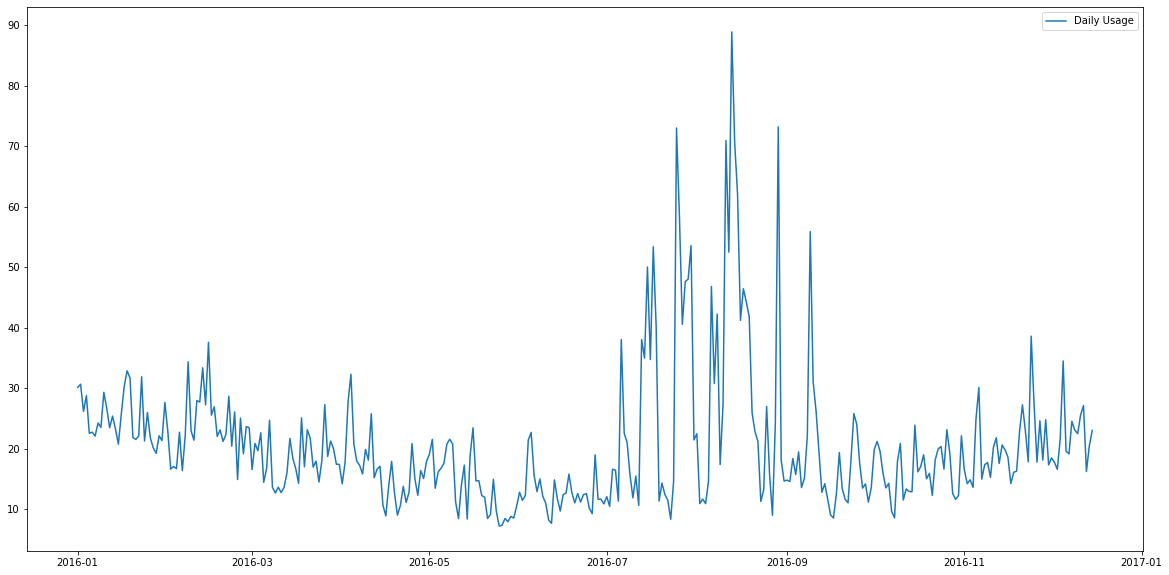

In [6]:
dataDay = energy_data.resample('H').mean()
dataDaily = dataDay.resample('D').sum()
plt.figure(figsize=(20,10))
plt.plot(dataDaily['use'], label ='Daily Usage')
plt.legend()
dataDaily['use']

# Decomposi

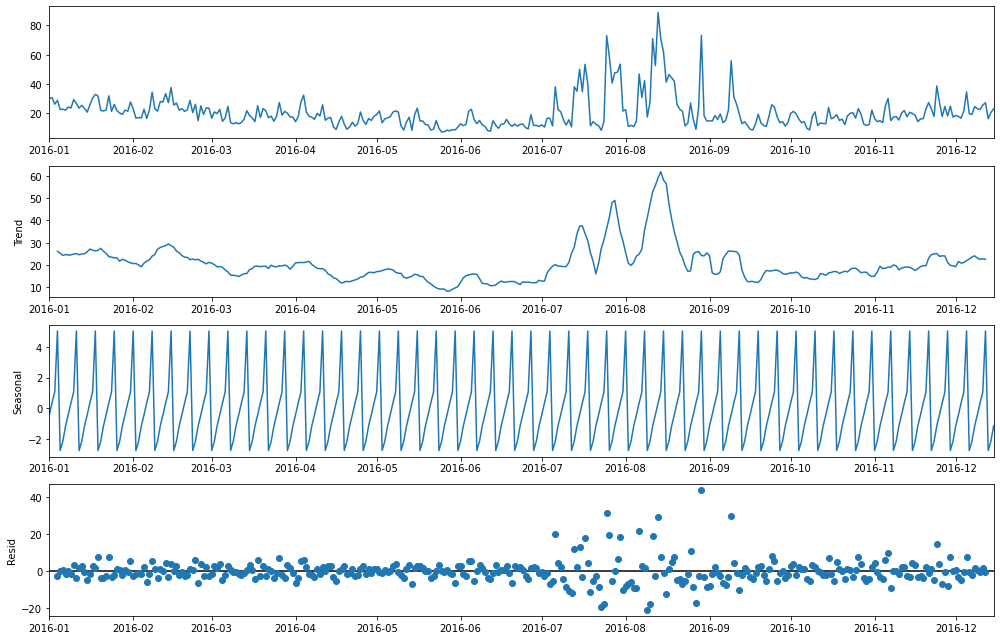

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
datause = dataDaily.iloc[:,0].values

#fig, ax = plt.subplots(figsize=(20,10))
plt.rcParams['figure.figsize'] = (14,9)
seasonal_decompose(dataDaily[['use']]).plot()
result = adfuller(datause)
plt.show()

In [8]:
X = dataDaily.iloc[:,0].values
result = adfuller(X)
print('ADF Stastitics: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key,value))

ADF Stastitics: -3.022708
p-value: 0.032827
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


In [9]:
#Converting the data into time series for train and test
day_timeSeries = pd.Series(dataDaily.use.values, index = dataDaily.index)
day_timeSeries

2016-01-01    30.169358
2016-01-02    30.680708
2016-01-03    26.187171
2016-01-04    28.818997
2016-01-05    22.561987
                ...    
2016-12-11    25.590984
2016-12-12    27.150711
2016-12-13    16.241008
2016-12-14    20.486863
2016-12-15    23.036400
Freq: D, Length: 350, dtype: float64

Split test and train

In [10]:
split_ratio = round(day_timeSeries.shape[0]*0.8)
train = day_timeSeries.iloc[:split_ratio]
test = day_timeSeries.iloc[split_ratio:]

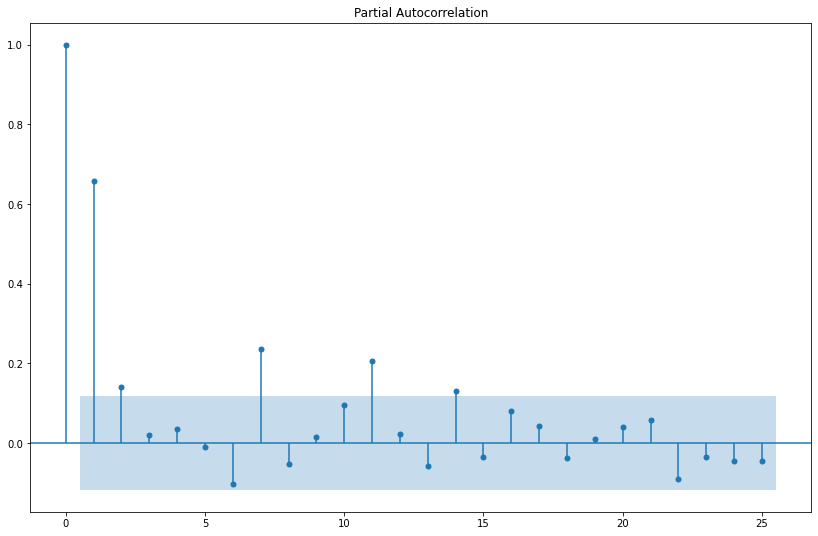

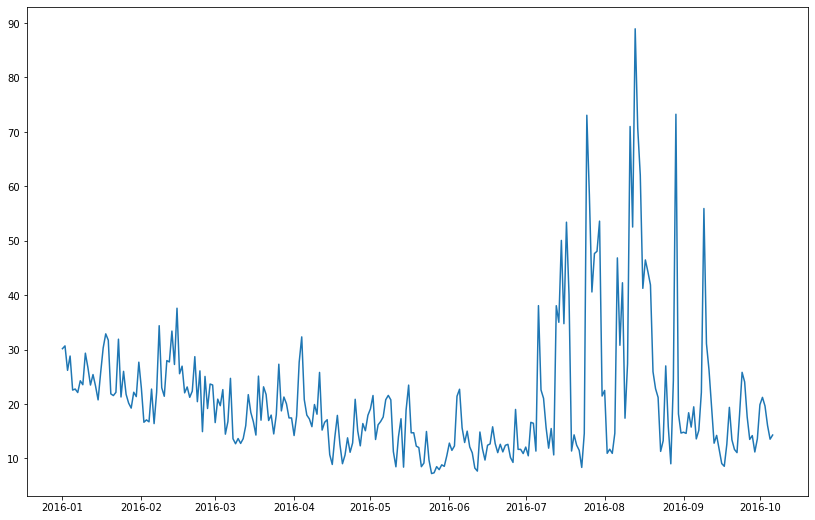

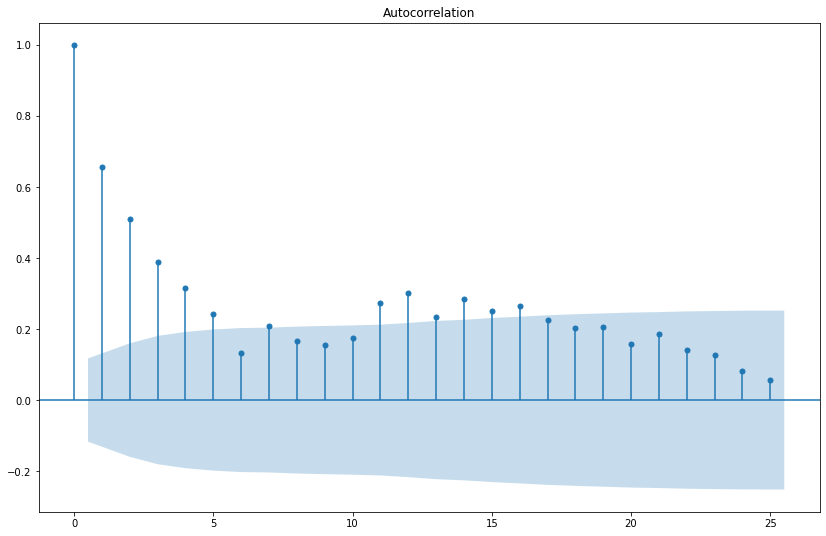

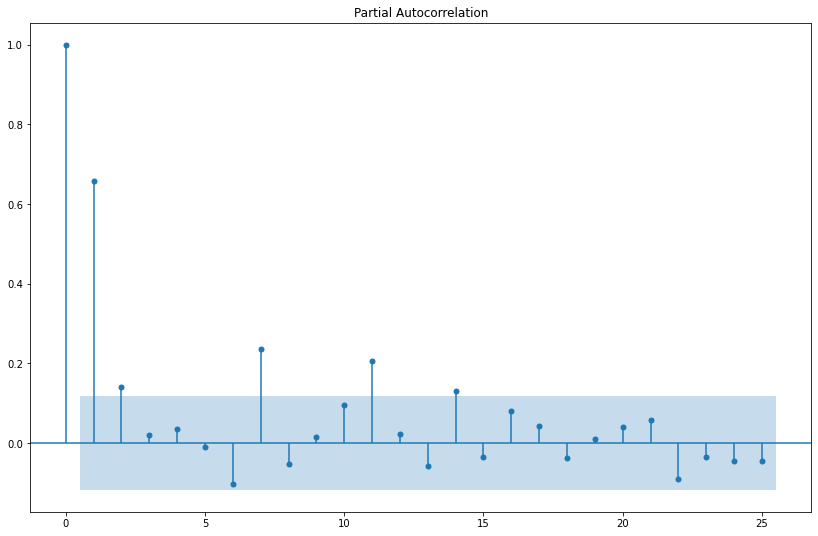

In [11]:
plt.plot(train)
plot_acf(train)
plot_pacf(train)

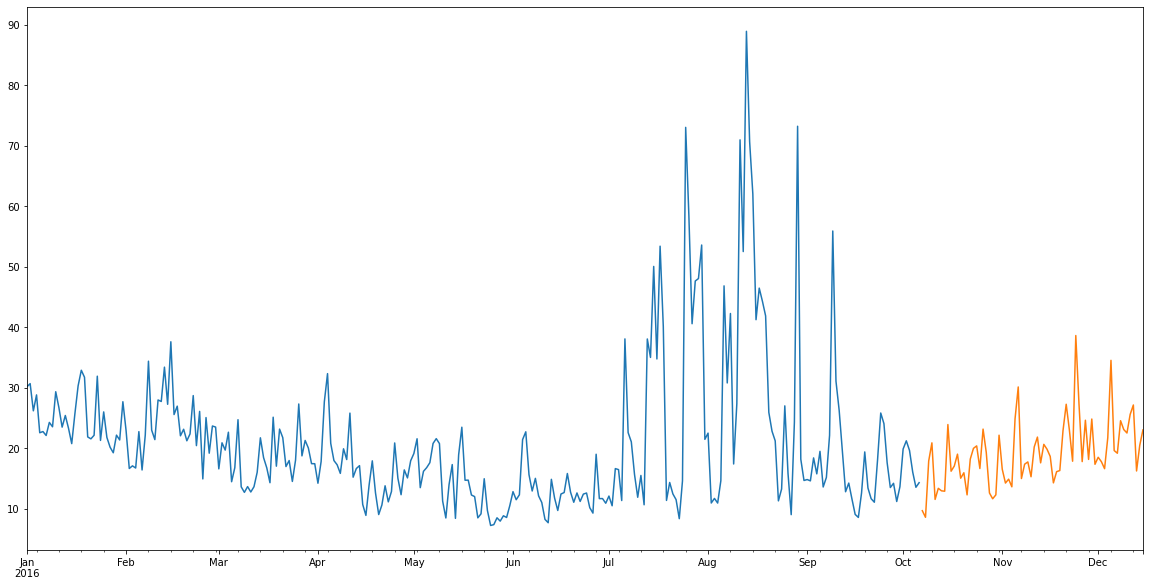

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
train.plot(ax=ax)
test.plot(ax=ax)
plt.show()

# Holt's Method

In [14]:
fit1 = Holt(train).fit(smoothing_level=0.8, smoothing_trend=0.2,optimized=False)
fcast1 = fit1.forecast(split_ratio).rename("Holt's linear trend")

fit2 = Holt(train, damped_trend=True).fit(smoothing_level=0.8, smoothing_trend=0.2)
fcast2 = fit2.forecast(split_ratio).rename("Additive damped trend")

fit3 = Holt(train, damped_trend=True).fit()
fcast3 = fit3.forecast(split_ratio).rename("Additive damped trend - Auto optimization")

C:\Users\User\anaconda3\envs\time-series-labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


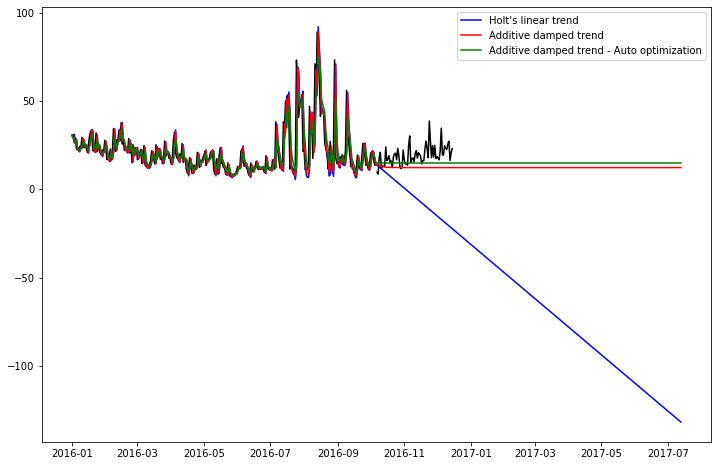

In [15]:
plt.figure(figsize=(12, 8))

plt.plot(train,color='black')
plt.plot(test,color='black')

plt.plot(fit1.fittedvalues, color='blue')
line1, = plt.plot(fcast1,color='blue')

plt.plot(fit2.fittedvalues, color='red')
line2, = plt.plot(fcast2,color='red')

plt.plot(fit3.fittedvalues,color='green')
line3, = plt.plot(fcast3, color='green')

plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

In [16]:
fit3.summary()

Dep. Variable:,None,No. Observations:,280
Model:,Holt,SSE,25650.143
Optimized:,True,AIC,1274.904
Trend:,Additive,BIC,1293.078
Seasonal:,None,AICC,1275.316
Seasonal Periods:,None,Date:,"Mon, 05 Apr 2021"
Box-Cox:,False,Time:,11:14:29
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5997021,alpha,True
smoothing_trend,0.000000,beta,True


In [17]:
#create rmse function
def rmse(predicted_val, true):
    return np.sqrt(np.mean((predicted_val - true)**2))

In [18]:
# Model 1 - Holt's linear trend
train_error = rmse(fit1.fittedvalues, train)
test_error = rmse(fcast1, test)
print("Holt-Winters (additive trend, additive seasonality)")
print(f"Training set error: {train_error}, Test set error: {test_error}")

Holt-Winters (additive trend, additive seasonality)
Training set error: 10.521522699876204, Test set error: 27.349668747815198


In [19]:
# Model 2 - Additive damped trend
model2_result = rmse(fcast2, test)
print("Additive damped trend")
print(f"Result: {model2_result}")

Additive damped trend
Result: 8.740251798439067


In [20]:
# Model 3 - Additive damped trend - Auto optimization
model3_result = rmse(fcast3, test)
print("Additive damped trend - Auto optimization")
print(f"Result: {model3_result}")

Additive damped trend - Auto optimization
Result: 7.0287604798207175


# Holt-Winters Method

As the dataset for daily usage does not have trend and the seasonality is additive, only trend='add' and seasonal='add' will be use for casting

In [21]:
fit = ExponentialSmoothing(train, seasonal_periods=7, trend='add',seasonal='add').fit()
fcast = fit.forecast(split_ratio).rename("Holt-Winters")

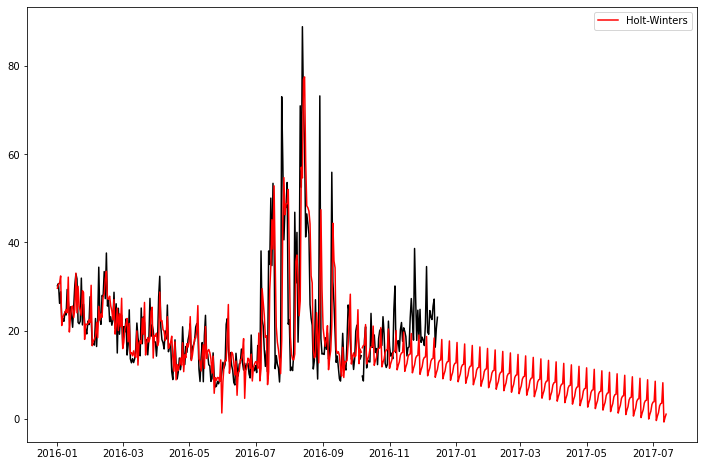

In [22]:
plt.figure(figsize=(12, 8))

plt.plot(train,color='black')
plt.plot(test,color='black')

plt.plot(fit.fittedvalues, color='red')
line1, = plt.plot(fcast,color='red')


plt.legend([line1], [fcast.name])

In [64]:
#create rmse function
def rmse(predicted_val, true):
    return np.sqrt(np.mean((predicted_val - true)**2))

In [65]:
# Model 1 - additive trend, additive seasonality
train_error = rmse(fit.fittedvalues, train)
test_error = rmse(fcast, test)
print("Holt-Winters (additive trend, additive seasonality)")
print(f"Training set error: {train_error}, Test set error: {test_error}")

Holt-Winters (additive trend, additive seasonality)
Training set error: 8.954092848796837, Test set error: 7.691483960060848


Test and prediction

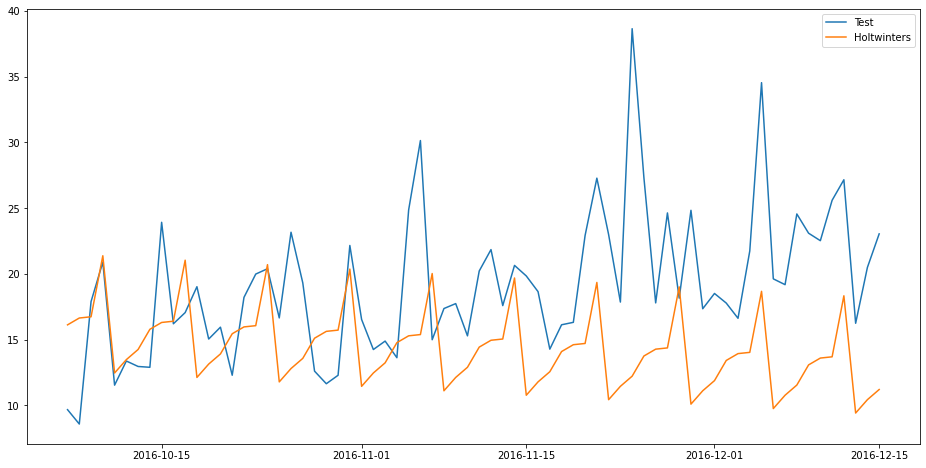

In [66]:
# make prediction
y = fit.forecast(split_ratio)
y_predicted=pd.DataFrame(y,index=test.index,columns=['Holt-Winters'])

plt.figure(figsize=(16,8))
plt.plot(test, label='Test')
plt.plot(y_predicted, label='Holtwinters')
plt.legend(loc='best')
plt.show()

In [67]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print(f'Mean Absolute Error = {mean_absolute_error(test,y_predicted)}')
print(f'Mean Squared Error = {mean_squared_error(test,y_predicted)}')

Mean Absolute Error = 6.066694379029124
Mean Squared Error = 59.158925507873285


In [68]:
result = math.sqrt(mean_squared_error(test,y_predicted))
print(f'RMSE = {result}')

RMSE = 7.691483960060847
